In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
cd

/root


In [ ]:
bd=pd.read_excel('/gdrive/MyDrive/CE/BDEX to UDM Data Mapping - May 13, 2021.xlsx')

In [ ]:
bd['udm_user_found']=bd['UDM Consumer User ID'].map({'No Match Found': False}).fillna(True)

In [ ]:
met_dict= {'email_address': 'count', 'udm_user_found': 'sum'}
bf= bd.loc[bd.Vendor=='DI'].groupby('Client Account AS400 ID').agg(met_dict).reset_index()
bf.columns=['as400id', 'emails', 'users_found']
bf['opportunity_size']= bf.emails- bf.users_found
bf['bdex']= 'Y'

In [ ]:
mf= pd.read_csv('/gdrive/MyDrive/CE/nummc.csv')

In [ ]:
mf.columns=['as400id', 'machine_count']

In [ ]:
bf.shape

(2215, 5)

In [ ]:
bf.merge(mf, how='inner', on= 'as400id').shape

(2202, 6)

In [ ]:
df=pd.read_csv('/gdrive/MyDrive/CE/uupm.csv')
df.columns= ['as400id', 'payment_type', 'weeknum', 'uniq_transactors', 'amt']

In [ ]:
ditch=[]
for a in df.as400id:
  try:
    int(a)
  except:
    ditch.append(a)
ditch.append('-303934')
ditch.append('0')
ditch.append('000000000')
ditch.append('999999999')
ditch = set(ditch)

In [ ]:
df1=df.loc[~df.as400id.isin(ditch)]

In [ ]:
df11=df1.loc[df.weeknum <= 16].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df11.columns=['UniqTxntrAll', 'AmtAll']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df12=df1.loc[(df.weeknum <= 16) & (df.payment_type=='App')].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df12.columns=['UniqTxntrApp', 'AmtApp']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df2=pd.concat([df11,df12], axis=1, join='outer').fillna(0).reset_index()
df2.columns= ['as400id', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp']

In [ ]:
import numpy as np
df2['UnitVendAlldollar']= df2.AmtAll/(np.where(df2.UniqTxntrAll==0, 1, df2.UniqTxntrAll)*100.0)
df2['UnitVendAppdollar']= df2.AmtApp/(np.where(df2.UniqTxntrApp==0, 1, df2.UniqTxntrApp)*100.0)

In [ ]:
df2.head()

,as400id,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar
0,03001478,45.1875,31829.6875,18.9375,13735.9375,7.043914,7.253300
1,03021438,8.2500,4895.6250,8.2500,4895.6250,5.934091,5.934091
2,04020589,1.1250,2579.6875,1.1250,235.9375,22.930556,2.097222
3,04318891,0.0000,109.3750,0.0000,0.0000,1.093750,0.000000
4,04334902,1.2500,1010.9375,1.2500,421.8750,8.087500,3.375000


In [ ]:
df3=bf.merge(mf, how='inner', on= 'as400id').merge(df2, how='inner', on='as400id')

In [ ]:
df3

,as400id,emails,users_found,opportunity_size,bdex,machine_count,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar
0,10824,14,2,12,Y,4,7.6250,6878.1250,7.6250,6437.5000,9.020492,8.442623
1,1100318,162,6,156,Y,12,11.8125,12281.2500,5.3750,5681.2500,10.396825,10.569767
2,1100331,51,3,48,Y,6,6.6875,7771.8750,1.6250,1479.6875,11.621495,9.105769
3,1100489,8,0,8,Y,7,3.3125,4950.0000,3.3125,2150.0000,14.943396,6.490566
4,1100690,28,0,28,Y,16,46.6875,41767.1875,22.5625,21192.1875,8.946118,9.392659
...,...,...,...,...,...,...,...,...,...,...,...,...
2134,920182,13,0,13,Y,4,5.6250,5895.3125,1.9375,1460.9375,10.480556,7.540323
2135,920187,27,0,27,Y,8,11.7500,15425.0000,4.2500,3514.0625,13.127660,8.268382
2136,920830,571,3,568,Y,24,30.4375,20656.2500,11.7500,8385.9375,6.786448,7.136968
2137,9279,226,13,213,Y,8,7.9375,12790.6250,4.2500,5271.8750,16.114173,12.404412


In [ ]:
df3['AlltxntrperMc']= df3.UniqTxntrAll/df3.machine_count

In [ ]:
df3.AlltxntrperMc.describe()

count    2139.000000
mean        1.397417
std         1.076453
min         0.000000
25%         0.593750
50%         1.190104
75%         1.928646
max         7.505208
Name: AlltxntrperMc, dtype: float64

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
AlltxntrperMc,2139,1.39742,1.07645,0,0.59375,1.1901,1.92865,7.50521


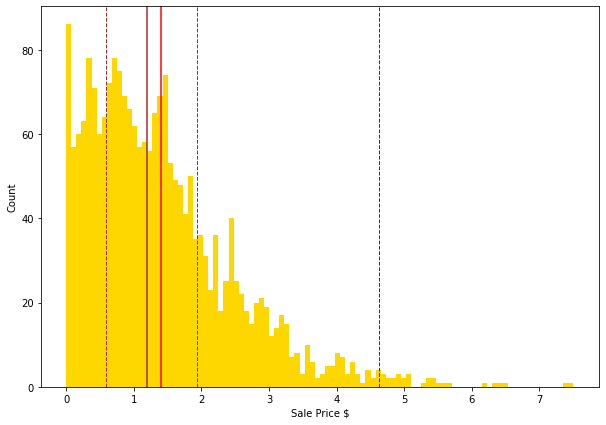

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(df3.AlltxntrperMc, color='gold', bins=100,log=False, histtype='bar')
# plt.hist(df3.AlltxntrperMc.sample(frac=.4, replace=False, random_state=42, axis=0), color='orange', bins=100,log=False, histtype='bar')
plt.xlabel('Sale Price $')
plt.ylabel('Count')
plt.axvline(df3.AlltxntrperMc.mean(), color='red', linestyle='solid', linewidth=1.5)
plt.axvline(df3.AlltxntrperMc.median(), color='brown', linestyle='solid', linewidth=1.5)
plt.axvline(df3.AlltxntrperMc.describe().loc['25%'], color='brown', linestyle='dashed', linewidth=1)
plt.axvline(df3.AlltxntrperMc.describe().loc['75%'], color='brown', linestyle='dashed', linewidth=1)
plt.axvline(df3.AlltxntrperMc.describe().loc['mean']+ 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# # plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.loc['std'], color='purple', linestyle='dashed', linewidth=1)
# plt.show()
df3.AlltxntrperMc.describe().reset_index().T

In [ ]:
def add_campaignflag(df, col='AlltxntrperMc', splits=[.4,.4,.2]):
  np.random.seed(42)
  df['dec']= pd.qcut(df[col], 10, labels=np.arange(10, 0, -1))
  dfs=[]
  for i,d in enumerate(list(df3.dec.unique())):
    df1= df.loc[df.dec==d]
    ixs= np.arange(df1.shape[0])
    np.random.shuffle(ixs)
    # print(i,d,len(ixs))
    df1['camp_flag']= None
    start=0
    for i,s in enumerate(splits):
      stop= start+int(round(s*len(df1),0))
      df1.loc[:,'camp_flag'].iloc[start:stop]= 'split_'+str(i)
      start = stop
      # print(i,d,stop,start,df1.camp_flag.value_counts())
    # print(d,df1.camp_flag.value_counts())
    dfs.append(df1)
  df4= pd.concat(dfs, axis=0)
  return(df4)

In [ ]:
df4=add_campaignflag(df3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [ ]:
df4.camp_flag= df4.camp_flag.map({'split_0': 'email', 'split_1': 'facebook', 'split_2':'control'})

In [ ]:
df4.camp_flag.value_counts().sum()

2139

In [ ]:
df4.groupby('dec')['AlltxntrperMc'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
dec,,,,,,,,
10,214.0,0.107273,0.075973,0.000000,0.031250,0.117932,0.176563,0.234375
9,214.0,0.356509,0.064258,0.238281,0.306392,0.359375,0.408906,0.463450
8,214.0,0.592238,0.069565,0.468750,0.531250,0.593750,0.656250,0.703125
7,214.0,0.814043,0.062190,0.704545,0.760417,0.812500,0.864583,0.929688
6,214.0,1.058253,0.077777,0.932292,0.989955,1.057586,1.125000,1.190104
5,217.0,1.326935,0.076033,1.190476,1.265625,1.332031,1.395833,1.453125
4,210.0,1.582854,0.083141,1.456250,1.501302,1.572173,1.656250,1.734375
3,218.0,1.943464,0.129124,1.742188,1.842882,1.937500,2.044922,2.187500
2,210.0,2.490217,0.180934,2.190104,2.343750,2.468750,2.627930,2.846875


In [ ]:
df4.columns

Index(['as400id', 'emails', 'users_found', 'opportunity_size', 'bdex',
       'machine_count', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp',
       'UnitVendAlldollar', 'UnitVendAppdollar', 'AlltxntrperMc', 'dec',
       'camp_flag'],
      dtype='object')

In [ ]:
df4.groupby('camp_flag')['AlltxntrperMc'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
camp_flag,,,,,,,,
control,423.0,1.419854,1.129708,0.0,0.609375,1.203125,1.972656,7.390625
email,858.0,1.391802,1.052393,0.0,0.580492,1.187500,1.917969,6.406250
facebook,858.0,1.391971,1.074483,0.0,0.613873,1.188802,1.890625,7.505208


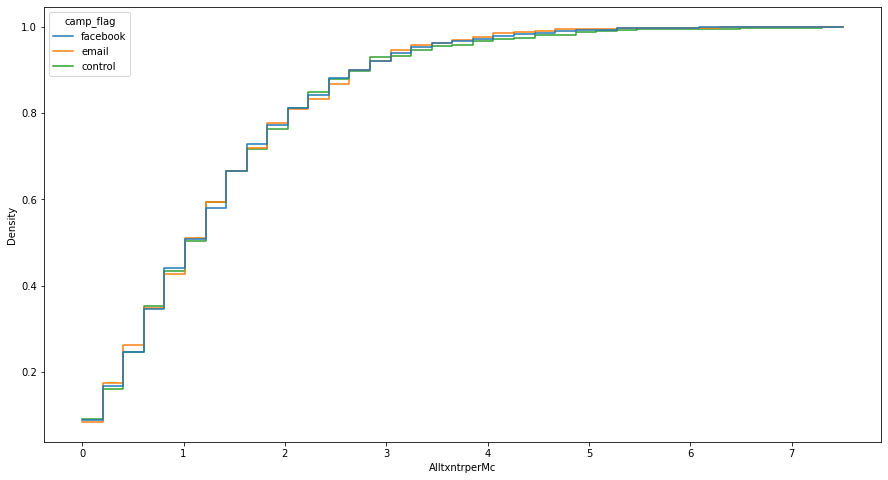

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(
    data=df4, x="AlltxntrperMc", hue="camp_flag",
    hue_order=["facebook", "email", "control"],
    log_scale=False, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,ax=ax
)

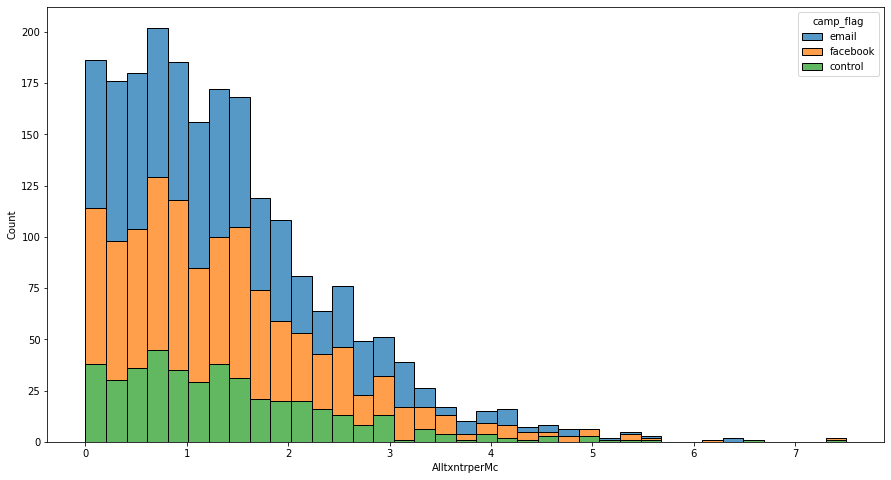

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df4, x="AlltxntrperMc", hue="camp_flag", multiple="stack", ax=ax)

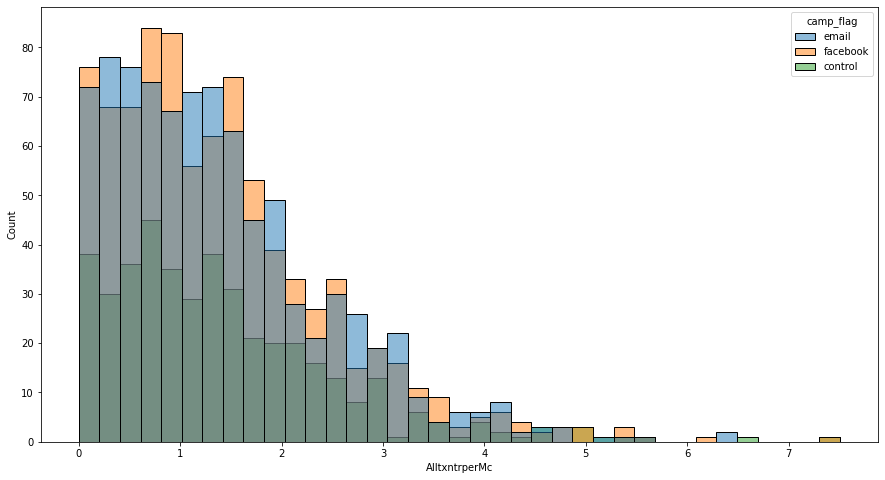

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df4, x="AlltxntrperMc", hue="camp_flag", multiple="layer",ax=ax)

In [ ]:
df4.head()

,as400id,emails,users_found,opportunity_size,bdex,machine_count,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar,AlltxntrperMc,dec,camp_flag
0,10824,14,2,12,Y,4,7.6250,6878.1250,7.6250,6437.5000,9.020492,8.442623,1.906250,3,email
11,1101128,17,2,15,Y,6,12.7500,18026.5625,7.1250,7660.9375,14.138480,10.752193,2.125000,3,email
30,1420340,239,25,214,Y,28,49.6250,33267.1875,24.1250,18198.4375,6.703715,7.543394,1.772321,3,email
33,1422532,8,1,7,Y,2,4.0625,3200.0000,4.0625,3200.0000,7.876923,7.876923,2.031250,3,email
40,1501219,17,2,15,Y,8,16.7500,18028.1250,9.9375,11123.4375,10.763060,11.193396,2.093750,3,email


In [ ]:
met_dict1= {'opportunity_size': 'sum','as400id': 'nunique', 'UniqTxntrAll': 'sum', 'machine_count':'sum','AlltxntrperMc': 'std'}

In [ ]:
df5=df4.groupby('camp_flag').agg(met_dict1)
df5['AlltxntrperMcMean']= df5.UniqTxntrAll/ df5.machine_count

In [ ]:
df5

,opportunity_size,as400id,UniqTxntrAll,machine_count,AlltxntrperMc,AlltxntrperMcMean
camp_flag,,,,,,
control,30816,423,7931.7500,5493,1.129708,1.443974
email,78983,858,15263.0625,9536,1.052393,1.600573
facebook,60907,858,12007.8125,8474,1.074483,1.417018


In [ ]:
(60907*.1+12007)/12007.0

1.5072624302490214

In [ ]:
tcats=['email', 'facebook']
tcon= 'control'
A_size= df5.loc[tcon, 'as400id']
A_mean= df5.loc[tcon, 'AlltxntrperMcMean']
A_var= df5.loc[tcon,'AlltxntrperMc']**2

In [ ]:
from statsmodels.stats.power import TTestPower
result=[]
for mean_incr in [.01,.02, 0.025, .03, .045, .05, .1]:
  for t in tcats:
    B_size= df5.loc[t, 'as400id']
    B_Mean= df5.loc[t, 'AlltxntrperMcMean']
    B_NewMean= B_Mean*(1+mean_incr)
    B_machines= df5.loc[t, 'machine_count']
    IncrVend= mean_incr*df5.loc[t,'UniqTxntrAll']
    ConvReq= IncrVend/df5.loc[t,'opportunity_size']
    B_var= df5.loc[t,'AlltxntrperMc']**2
    s= np.sqrt(((A_size-1)*A_var+(B_size-1)*B_var)/(A_size+B_size-2))
    d= (B_NewMean- A_mean)/s
    power = TTestPower()
    n_test = power.solve_power(nobs= B_size, effect_size = d, alpha = 0.05)
    print(mean_incr,t,B_Mean,B_NewMean,B_machines,IncrVend,ConvReq, n_test)
    result.append([mean_incr,t,B_Mean,B_NewMean,B_machines,IncrVend,100*ConvReq, 100*n_test])

0.01 email 1.6005728292785235 1.6165785575713087 9536 152.630625 0.0019324490713191447 0.9967612412659663
0.01 facebook 1.4170182322397924 1.4311884145621903 8474 120.078125 0.0019714995813289115 0.06352455123651393
0.02 email 1.6005728292785235 1.632584285864094 9536 305.26125 0.0038648981426382895 0.9992024103362351
0.02 facebook 1.4170182322397924 1.4453585968845883 8474 240.15625 0.003942999162657823 0.05015734553876261
0.025 email 1.6005728292785235 1.6405871500104865 9536 381.5765625 0.004831122678297862 0.9996294283602956
0.025 facebook 1.4170182322397924 1.4524436880457872 8474 300.1953125 0.004928748953322278 0.05590900141116713
0.03 email 1.6005728292785235 1.6485900141568792 9536 457.89187499999997 0.005797347213957434 0.999835283440173
0.03 facebook 1.4170182322397924 1.4595287792069862 8474 360.234375 0.005914498743986734 0.07008729106902287
0.045 email 1.6005728292785235 1.672598606596057 9536 686.8378124999999 0.00869602082093615 1.0
0.045 facebook 1.4170182322397924 1.4

In [ ]:
result

[[0.01,
  'email',
  1.6005728292785235,
  1.6165785575713087,
  9536,
  152.630625,
  0.0019324490713191447,
  0.9967612412659663],
 [0.01,
  'facebook',
  1.4170182322397924,
  1.4311884145621903,
  8474,
  120.078125,
  0.0019714995813289115,
  0.06352455123651393],
 [0.02,
  'email',
  1.6005728292785235,
  1.632584285864094,
  9536,
  305.26125,
  0.0038648981426382895,
  0.9992024103362351],
 [0.02,
  'facebook',
  1.4170182322397924,
  1.4453585968845883,
  8474,
  240.15625,
  0.003942999162657823,
  0.05015734553876261],
 [0.05,
  'email',
  1.6005728292785235,
  1.6806014707424497,
  9536,
  763.153125,
  0.009662245356595723,
  1.0],
 [0.05,
  'facebook',
  1.4170182322397924,
  1.4878691438517821,
  8474,
  600.390625,
  0.009857497906644556,
  0.21710354931243495],
 [0.1,
  'email',
  1.6005728292785235,
  1.760630112206376,
  9536,
  1526.30625,
  0.019324490713191447,
  1.0],
 [0.1,
  'facebook',
  1.4170182322397924,
  1.5587200554637717,
  8474,
  1200.78125,
  0.01971

In [ ]:
df4.columns

Index(['as400id', 'emails', 'users_found', 'opportunity_size', 'bdex',
       'machine_count', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp',
       'UnitVendAlldollar', 'UnitVendAppdollar', 'AlltxntrperMc', 'dec',
       'camp_flag'],
      dtype='object')

# Other Stuff

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return(df_train, df_val, df_test)

In [ ]:
import pandas as pd

positions = {"least": 0.277220, "left": 0.250000, "right": 0.250000, "left-center": 0.141244, "right-center": 0.081536}
data = [['title-{}-{}'.format(i, position), position] for i in range(1000) for position in positions.keys()]
frame = pd.DataFrame(data=data, columns=['title', 'position'])
print(frame.shape)


def sample(obj, replace=False, total=1000):
    return obj.sample(n=int(positions[obj.name] * total), replace=replace)

result = frame.groupby('position', as_index=False).apply(sample).reset_index(drop=True)
print(result.groupby('position').agg('count'))

(5000, 2)
              title
position           
least           277
left            250
left-center     141
right           250
right-center     81


In [ ]:
frame.shape

(5000, 2)